In [1]:
import os.path as osp
import torch
from torch_geometric.datasets import PPI
from torch_geometric.utils import add_remaining_self_loops

#### load the graph

In [2]:
dataset = 'PPI'
path = osp.join('../..', 'data', dataset)

test_dataset = PPI(path, split='test')

# graph = test_dataset[0]
# graph.edge_index, _ = add_remaining_self_loops(graph.edge_index, num_nodes=graph.num_nodes)

In [3]:
for n in range(len(test_dataset)):
    test_dataset[n].edge_index, _ = add_remaining_self_loops(test_dataset[n].edge_index)
    if n == 0:
        break

In [4]:
test_dataset[0].edge_index

tensor([[   0,    0,    0,  ..., 3213, 3213, 3213],
        [3108,  165, 1864,  ..., 2890, 3075, 3134]])

In [5]:
test_dataset[0].edge_index

tensor([[   0,    0,    0,  ..., 3213, 3213, 3213],
        [3108,  165, 1864,  ..., 2890, 3075, 3134]])

In [6]:
g.edge_index[:, :100648]

NameError: name 'g' is not defined

In [7]:
g = test_dataset[0]

In [8]:
g

Data(edge_index=[2, 100648], x=[3224, 50], y=[3224, 121])

#### use DGL to check graph degrees

In [251]:
import dgl
import matplotlib.pyplot as plt

In [237]:
gg = dgl.DGLGraph()

gg.add_nodes(g.x.size(0))
gg.add_edges(*g.edge_index)

In [290]:
gg.in_degrees()[3000]

tensor(530)

In [270]:
gg.in_degrees()[gg.in_degrees().nonzero()].squeeze()

tensor([19,  2, 24,  ..., 15,  6, 17])

In [277]:
gg.in_degrees().float().mean()

tensor(31.2184)

In [297]:
gg.successors(10)
gg.in_edges([10, 1])

(tensor([3000,   16,   67]), tensor([10,  1,  1]))

#### load the learned attention scores

In [9]:
attn_path = osp.join('../saved_models', dataset.lower(), 'temp_model_test0-attn.pt') 

In [10]:
attn = torch.load(attn_path, map_location='cpu')

In [11]:
attn[0].size()

torch.Size([100648, 8])

In [12]:
add_remaining_self_loops??

In [13]:
attn[-1::-1]

[tensor([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [1.],
         [1.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 1., 0., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.]]), tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 1.,  ..., 0., 1., 0.],
         [1., 1., 1.,  ..., 1., 1., 1.]])]

#### check the size of the receptive field and the actual number of used nodes

In [14]:
def related_nodes_1layer(edge_index, attn, node_id, layer=3):
    """find all related nodes based on the hard attention, in a single attention layer"""
    residual = True
    
    related_nodes = []
    att = attn[layer - 1]
    for nh in range(att.size(1)):
        e_pick = edge_index[:, att[:, nh].squeeze().bool()]
        related_nodes.append(e_pick[0][(e_pick[1] == node_id).nonzero()].item())
    if residual:
        related_nodes.append(node_id)
    
    return related_nodes


def related_nodes_all(edge_index, attn, node_id, layer=3):
    """find all related nodes based on the hard attention, for all layers up to a layer number"""
    related_nodes = [related_nodes_1layer(edge_index, attn, node_id, layer=layer)]
    layer -= 1
    while layer > 0:
        related_nodes_cur = []
        for n in related_nodes[-1]:
            related_nodes_cur += related_nodes_1layer(edge_index, attn, n, layer=layer)
        related_nodes.append(related_nodes_cur)
        layer -= 1
    return related_nodes


from collections import Counter
def related_nodes_all_unique(edge_index, attn, node_id, layer=3):
    """find all related nodes based on the hard attention, for all layers up to a layer number.
    The node ids returned are unique for each layer, along with an importance number (roughly the number of times being selected).
    """
    related_nodes = []
    
    related_nodes_last = Counter([node_id])
    while layer > 0:
        related_nodes_cur = Counter()
        for n in related_nodes_last:
            node_list = related_nodes_1layer(edge_index, attn, n, layer=layer)
            related_nodes_cur += Counter(node_list)
            for k in related_nodes_cur:
                related_nodes_cur[k] *= related_nodes_last[n]
        related_nodes_last = related_nodes_cur
        
        related_nodes.append(related_nodes_cur)
        layer -= 1
    return related_nodes

In [190]:
related_nodes_1layer(g.edge_index, attn, 0, 1)

[1864, 163, 163, 633, 165, 165, 3149, 685, 0]

In [180]:
rela_n0 = related_nodes_all(g.edge_index, attn, 0, 3)

In [185]:
len(rela_n0[2])

162

In [191]:
import itertools

In [197]:
len(set(itertools.chain.from_iterable(rela_n0)))

57

In [644]:
rela_n0_u = related_nodes_all_unique(g.edge_index, attn, 0, 3)

In [645]:
rela_n0_u

[Counter({2771: 1, 0: 1}),
 Counter({71: 4,
          1131: 4,
          2771: 3,
          1804: 1,
          634: 2,
          685: 1,
          1230: 1,
          569: 1,
          0: 1}),
 Counter({479: 288,
          1765: 96,
          1769: 96,
          2677: 192,
          183: 96,
          71: 96,
          2020: 48,
          40: 48,
          1398: 72,
          1825: 24,
          1131: 30,
          2279: 18,
          824: 6,
          2154: 14,
          0: 7,
          2771: 6,
          2603: 2,
          2313: 3,
          893: 2,
          2198: 5,
          1326: 2,
          1530: 2,
          2190: 2,
          1804: 2,
          275: 2,
          163: 4,
          1022: 2,
          2372: 4,
          2993: 2,
          3169: 2,
          634: 2,
          2961: 1,
          1444: 1,
          625: 1,
          434: 1,
          2891: 1,
          1748: 1,
          2181: 1,
          685: 2,
          1574: 1,
          2414: 1,
          2513: 2,
          20

In [18]:
def neighbor_nhops(edge_index, node_id, hop=1):
    """find all neighboring nodes included in n-hops.
    
    Undirected graph only.
    """
    neighbor = []
    neighbor_cur = edge_index[1][edge_index[0] == node_id]
    neighbor.append(neighbor_cur)
    while hop > 1:
        neighbor_cur_temp = []
        for n in neighbor_cur:
            neighbor_cur_temp.append(neighbor_nhops(edge_index, n.item(), hop=1)[0])
        neighbor_cur = torch.cat(neighbor_cur_temp, dim=0)
        neighbor.append(neighbor_cur)
        hop = hop - 1
    return neighbor

In [17]:
nei_n0 = neighbor_nhops(g.edge_index, 0, 3)
print(nei_n0)
print('number of unique neighbors in each hop:')
print([th.unique().numel() for th in nei0])
print('number of unique neighbors in total:')
print(torch.cat(nei0, dim=0).unique().numel())

NameError: name 'nei0' is not defined

#### check a single node

In [19]:
node_id = 10
attn_layer = len(attn)

In [20]:
nei = neighbor_nhops(g.edge_index, node_id, 3)
print(nei)
print('number of unique neighbors in each hop:')
print([th.unique().numel() for th in nei])
print('number of unique neighbors in total:')
print(torch.cat(nei, dim=0).unique().numel())

[tensor([3000]), tensor([   0,    6,   10,   11,   21,   32,   55,   64,   71,   72,   73,   98,
         111,  114,  118,  144,  145,  146,  153,  154,  166,  170,  176,  190,
         191,  195,  198,  202,  209,  212,  217,  219,  223,  228,  229,  237,
         258,  262,  269,  270,  273,  274,  278,  286,  297,  298,  311,  313,
         329,  336,  338,  340,  341,  347,  351,  354,  359,  361,  362,  365,
         389,  395,  402,  410,  423,  426,  428,  441,  446,  456,  460,  465,
         469,  474,  479,  489,  490,  494,  503,  513,  521,  543,  546,  549,
         554,  562,  563,  566,  576,  578,  580,  581,  585,  589,  596,  609,
         613,  615,  620,  621,  622,  630,  631,  639,  642,  643,  646,  649,
         653,  655,  657,  660,  662,  679,  685,  687,  690,  695,  704,  719,
         722,  725,  734,  735,  737,  756,  758,  765,  770,  779,  784,  791,
         792,  793,  794,  798,  799,  809,  816,  817,  819,  821,  823,  828,
         837,  840,  84

In [21]:
rela = related_nodes_all(g.edge_index, attn, node_id, attn_layer)
print('actual number of nodes dependent on:')
print(len(set(itertools.chain.from_iterable(rela))))
len(set(rela[-1]))

actual number of nodes dependent on:


NameError: name 'itertools' is not defined

In [22]:
rela_unique = related_nodes_all_unique(g.edge_index, attn, node_id, attn_layer)
print('actual number of nodes dependent on:')
print(len(rela_unique[-1]))

actual number of nodes dependent on:
57


#### check all the nodes to see if every edge is used in hard attention

In [25]:
# node_id = 10
attn_layer = len(attn)

In [26]:
g.x.size(0)

3224

In [34]:
from tqdm import tqdm

used_edges = set()
for node_id in tqdm(range(g.x.size(0))):
    try:
        rela_unique = related_nodes_all_unique(g.edge_index, attn, node_id, attn_layer)
    except:
        pass
    used_edges.update(set(rela_unique[-1].keys()))


 28%|██▊       | 894/3224 [00:39<01:45, 22.15it/s]


 55%|█████▍    | 1765/3224 [01:18<00:57, 25.51it/s]


 82%|████████▏ | 2652/3224 [01:58<00:27, 20.61it/s]


100%|██████████| 3224/3224 [02:23<00:00, 22.40it/s]

In [40]:
len(used_edges)

3197

In [41]:
g.x.size()

torch.Size([3224, 50])

In [46]:
g.edge_index.size()

torch.Size([2, 100648])

#### draw subgraph (use DGL)

In [306]:
sg = gg.subgraph(list(set(rela[-1])))

In [308]:
sg

DGLGraph(num_nodes=57, num_edges=284,
         ndata_schemes={}
         edata_schemes={})

In [309]:
sg.parent_nid

tensor([ 258, 1412, 2181, 3205, 2313, 2314,  649,   10, 1549,  527, 2961,  914,
         146, 2836, 2198, 1182, 1444, 1829, 1065,  685, 1454, 2991,  434, 2355,
         821, 1976,  313, 3000,  955, 2233, 1726,  190, 2880,  323, 2372,  581,
        1603, 2503,   73, 2122, 2891, 3018, 1748, 2773,  212, 2136, 1755, 1756,
         347, 3167, 2656, 1257, 3053, 2928,  625, 2292,  889])

In [350]:
import networkx as nx
sg_nx = sg.to_networkx().to_undirected()

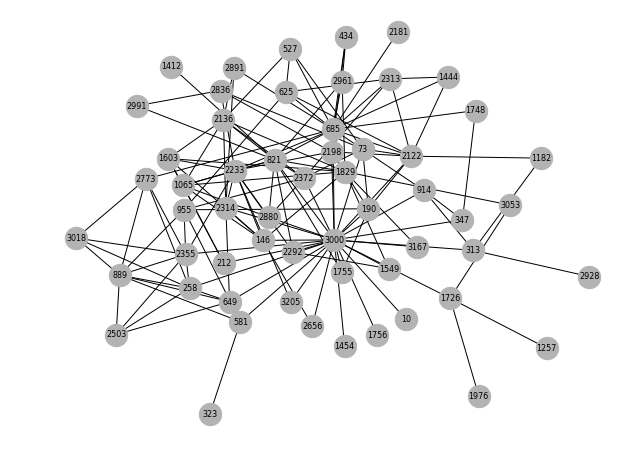

In [387]:
# sg_nx = nx.ego_graph(sg_nx, 7, 5)
pos = nx.kamada_kawai_layout(sg_nx)
# pos = nx.spring_layout(sg_nx)
plt.figure(figsize=(8, 6))
nx.draw(sg_nx, pos, with_labels=True, node_size=500, node_color=[[.7, .7, .7]], font_size=8,
        labels={i: sg.parent_nid[i].item() for i in range(sg.number_of_nodes())})

Actual nodes that are used with weights indicated by size

In [656]:
sg = gg.subgraph(list(rela_unique[-1].keys()))
node_weight = (list(rela_unique[-1].values()))

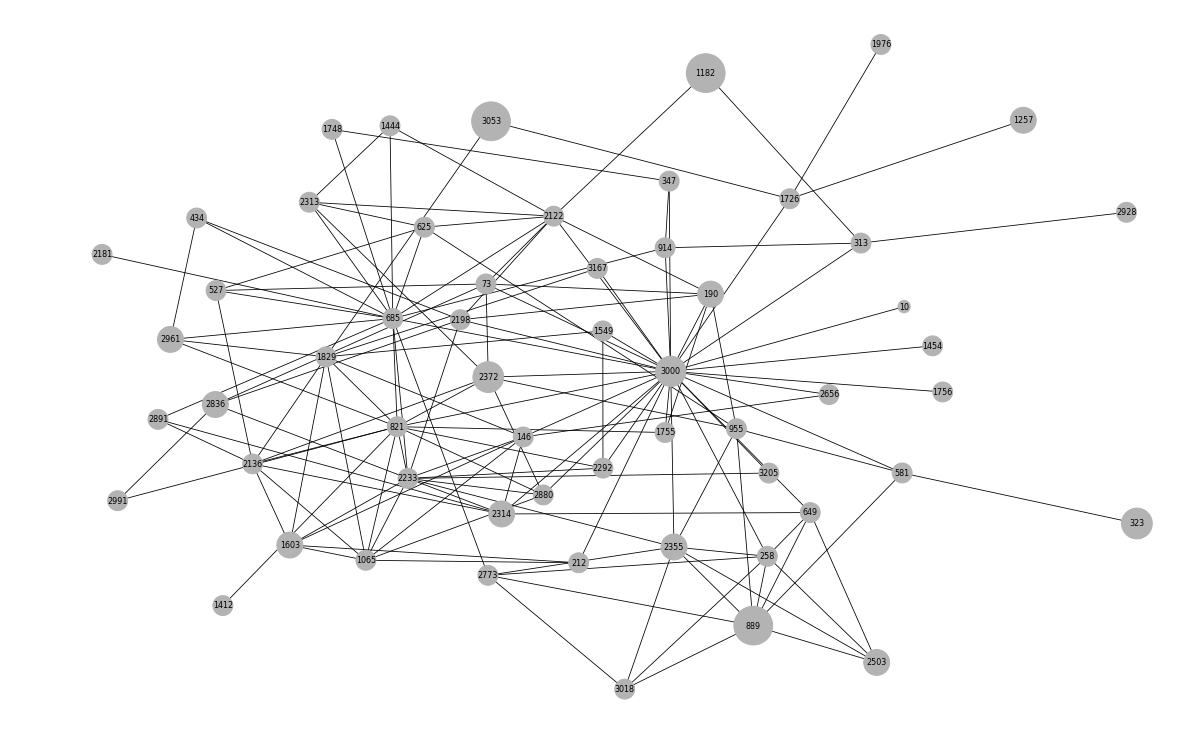

In [700]:
import networkx as nx
sg_nx = sg.to_networkx().to_undirected()
# sg_nx = nx.ego_graph(sg_nx, 7, 5)
pos = nx.kamada_kawai_layout(sg_nx)
# pos = nx.spring_layout(sg_nx)
node_size_max = 1500
node_size_min = 150
node_size = [(node_size_max - node_size_min) / (max(node_weight) - min(node_weight)) * (x - min(node_weight)) + node_size_min
             for x in node_weight]
plt.figure(figsize=(16, 10))
nx.draw(sg_nx, pos, with_labels=True, node_size=node_size, node_color=[[.7, .7, .7]], font_size=8, width=0.8,
        labels={i: sg.parent_nid[i].item() for i in range(sg.number_of_nodes())})
plt.savefig('ppi_test0-n10_graph.png', dpi=300)

Neighbors

In [384]:
sg_nei = nx.ego_graph(gg.to_networkx(), 10, 2)

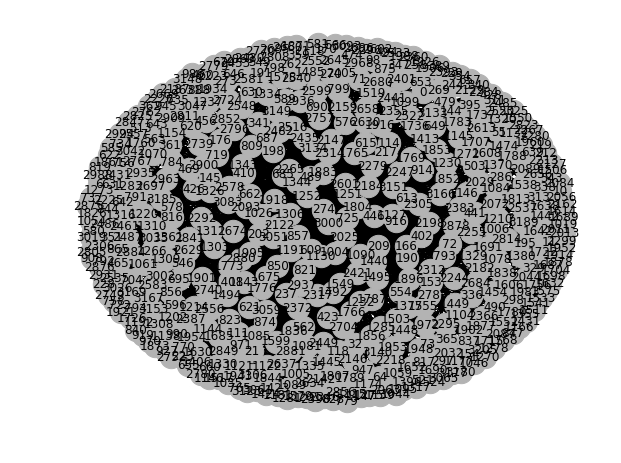

In [385]:
pos = nx.kamada_kawai_layout(sg_nei)
# pos = nx.spring_layout(sg_nx)
plt.figure(figsize=(8, 6))
nx.draw(sg_nei, pos, with_labels=True, node_size=500, node_color=[[.7, .7, .7]])

#### construct a tree using the learned hard attention

In [426]:
def related_nodes_tree(edge_index, attn, node_id, layer=3):
    """final all related nodes based on the hard attention, for all layers up to a layer number, and build a dependency tree graph"""
    # define the tree graph
    tree = dgl.DGLGraph()
    tree.add_nodes(1)
    node_mappings = {0: node_id}
    
    # get the dependent nodes from the current layer
    related_nodes = []
    related_nodes_cur = related_nodes_1layer(edge_index, attn, node_id, layer=layer)
    related_nodes_cur_unique = sorted(list(set(related_nodes_cur)))
    related_nodes.append(related_nodes_cur)
    
    # uniquely map these nodes to the new nodes in the tree
    node_mappings_cur = {i + tree.number_of_nodes(): n for i, n in enumerate(related_nodes_cur_unique)}
    node_mappings_cur_reverse = {v: k for k, v in node_mappings_cur.items()}
    node_mappings.update(node_mappings_cur)
    
    # add the new nodes and edges in the dependency tree
    tree.add_nodes(len(related_nodes_cur_unique))
    # note: to add multi-edges in cases where the same edge is picked by hard attention
    tree.add_edges([node_mappings_cur_reverse[n] for n in related_nodes_cur], 0)    
    
    layer -= 1
    while layer > 0:
        related_nodes_last = related_nodes_cur_unique
        related_nodes_last_tree = [node_mappings_cur_reverse[n] for n in related_nodes_cur_unique]
        related_nodes_cur = []
        related_nodes_cur_list = []
        for n in related_nodes_last:
            related_nodes_cur_list.append(related_nodes_1layer(edge_index, attn, n, layer=layer))
            related_nodes_cur += related_nodes_cur_list[-1]
        # uniquely map the new nodes to grow the tree
        related_nodes_cur_unique = sorted(list(set(related_nodes_cur)))
        node_mappings_cur = {i + tree.number_of_nodes(): n for i, n in enumerate(related_nodes_cur_unique)}
        node_mappings_cur_reverse = {v: k for k, v in node_mappings_cur.items()}
        node_mappings.update(node_mappings_cur)
        # add the new nodes and edges in the dependency tree
        tree.add_nodes(len(related_nodes_cur_unique))
        # note: to add multi-edges in cases where the same edge is picked by hard attention
        for i, p in enumerate(related_nodes_last_tree):
            tree.add_edges([node_mappings_cur_reverse[n] for n in related_nodes_cur_list[i]], p)
        
        related_nodes.append(related_nodes_cur)
        layer -= 1
    return related_nodes, tree, node_mappings

In [611]:
node_id = 10
related_nodes, tree, node_mappings = related_nodes_tree(g.edge_index, attn, node_id, layer=3)

In [612]:
tree

DGLGraph(num_nodes=70, num_edges=110,
         ndata_schemes={}
         edata_schemes={})

In [613]:
# number of unique nodes that are actually used
s = set()
for k, v in node_mappings.items():
    s.add(v)
len(list(s))

57

In [614]:
tree.edges()  # multi-edges

(tensor([ 2,  1, 12, 12, 12, 12, 12, 12, 12, 12,  3,  8,  7,  4, 11,  9,  5,  6,
         10, 12, 65, 65, 65, 65, 65, 65, 65, 65, 13, 16, 16, 59, 23, 55, 55, 46,
         59, 14, 44, 50, 53, 39, 32, 39, 57, 53, 15, 54, 66, 58, 54, 56, 29, 26,
         56, 18, 33, 33, 33, 30, 62, 65, 33, 33, 19, 31, 29, 29, 20, 20, 29, 29,
         20, 24, 63, 52, 36, 25, 22, 61, 41, 48, 27, 63, 47, 64, 35, 55, 60, 42,
         51, 28, 67, 34, 45, 67, 67, 34, 67, 67, 40, 17, 43, 38, 21, 68, 37, 49,
         69, 65]),
 tensor([ 0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,
          6,  6,  7,  7,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,
          8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10,
         10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12,
         

draw the dependency tree

In [719]:
def plot_tree(g):
    plt.figure(figsize=(24, 10))
    pos = nx.nx_agraph.graphviz_layout(g, prog='dot')
    nx.draw(g, pos, with_labels=True, node_size=300, labels=node_mappings, font_size=8,
            node_color=[[.5, .5, .5]], arrowsize=6, width=0.4, edge_color='r', style='dotted')
#     plt.savefig('ppi_test0-n10_tree.png')
    plt.show()


def to_multidi(g):
    m = nx.MultiDiGraph()
    m.add_node(g.number_of_nodes())
    m.add_edges_from(zip(tree.edges()[0].numpy().tolist(), tree.edges()[1].numpy().tolist()))
    return m

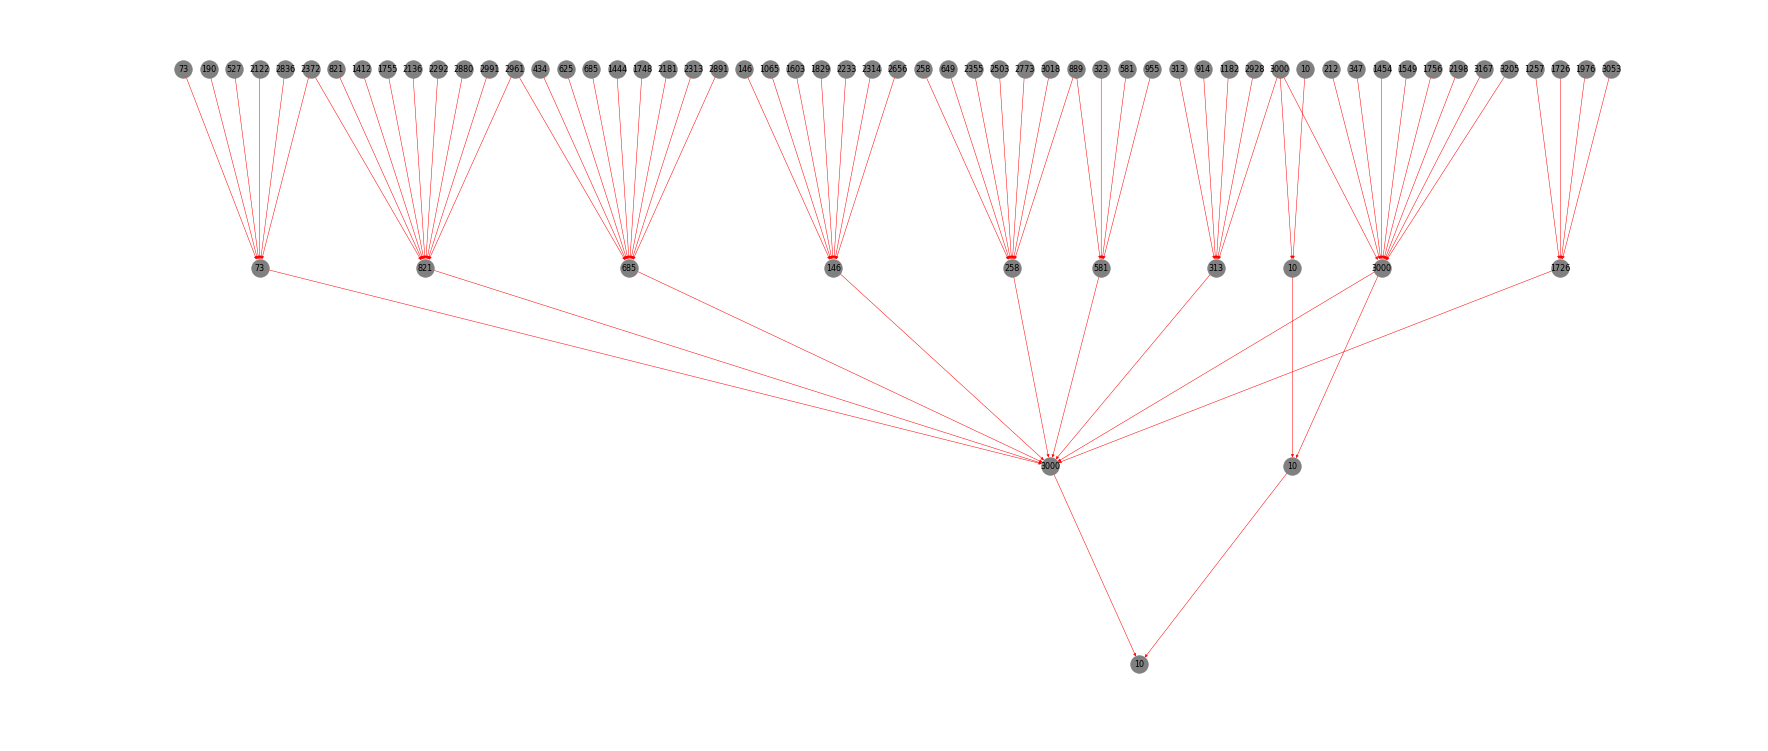

In [675]:
plot_tree(tree.to_networkx())    # this suppress the multi-edges

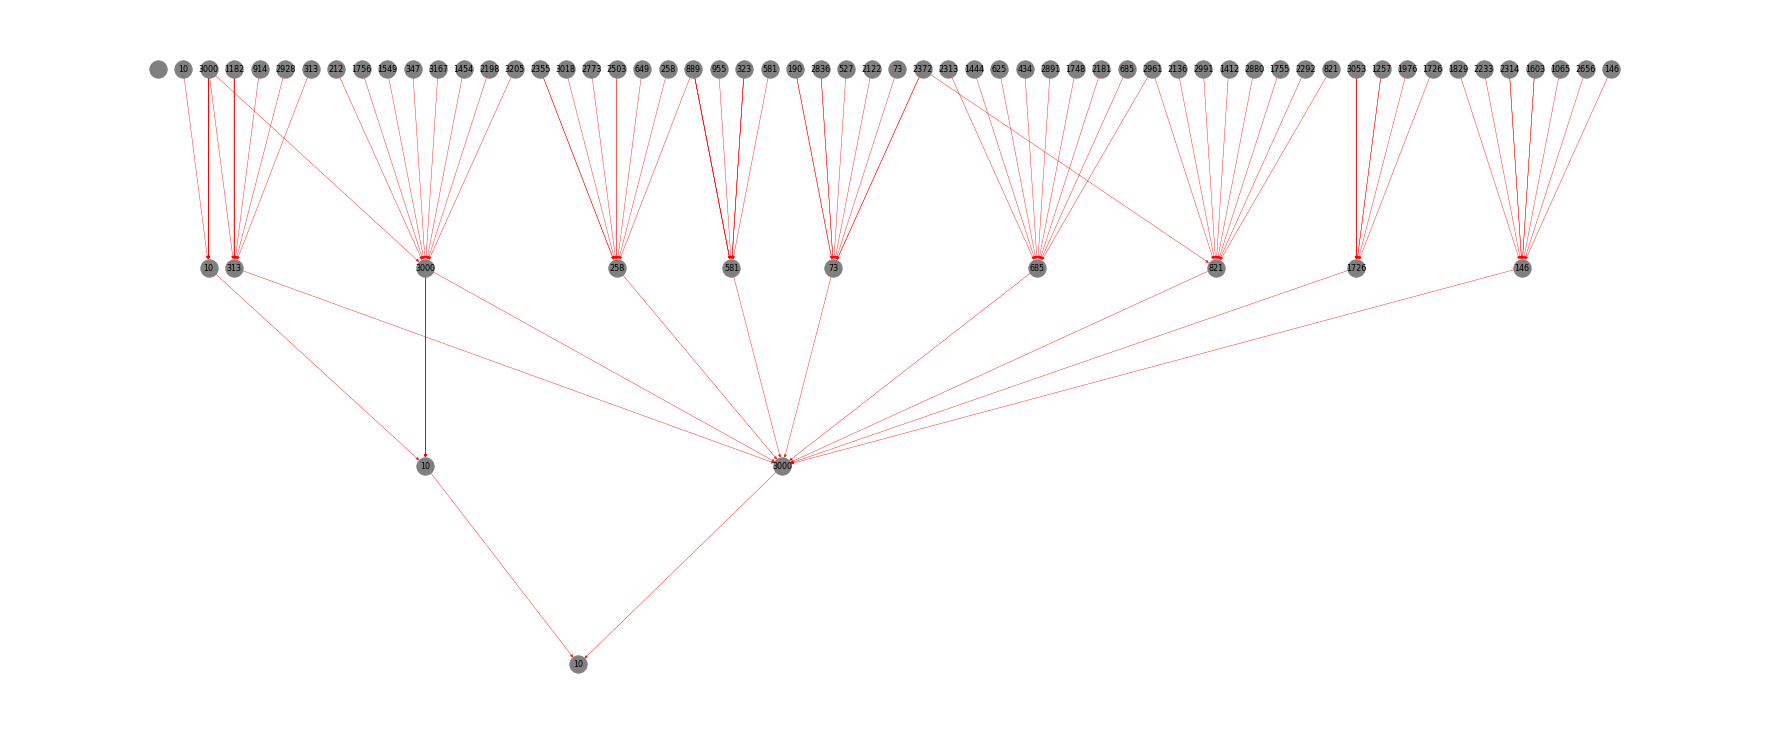

In [718]:
plot_tree(to_multidi(tree))

In [720]:
gg.successors(581)

tensor([ 323,  824,  889,  955, 3000])

In [721]:
gg

DGLGraph(num_nodes=3224, num_edges=100648,
         ndata_schemes={}
         edata_schemes={})